<a href="https://colab.research.google.com/github/yelmokht/nuclei-segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ROOT_PATH = '/content/'
DRIVE_PATH = ROOT_PATH + "drive/MyDrive/Colab Notebooks/"
SOURCE_PATH = DRIVE_PATH + 'data-science-bowl-2018.zip'
UNZIPPED_PATH = ROOT_PATH + 'unzipped/'
DESTINATION_PATH = DATA_PATH = ROOT_PATH + 'dsb_2018/'
TRAIN_PATH = DATA_PATH + 'stage1_train/'
TEST_1_PATH = DATA_PATH + 'stage1_test/'
TEST_2_PATH = DATA_PATH + 'stage2_test/'
STAGE_1_PATH = DATA_PATH + 'stage1_test/'
STAGE_2_PATH = DATA_PATH + 'stage2_test/'
STAGE_1_SOLUTION_PATH = DATA_PATH + 'stage1_solution/stage1_solution.csv'
STAGE_2_SOLUTION_PATH = DATA_PATH + 'stage2_solution/stage2_solution.csv'
IMAGE_HEIGHT = MASK_HEIGHT = 256
IMAGE_WIDTH = MASK_WIDTH = 256
IMAGE_NUM_CHANNELS = 3
MASK_NUM_CHANNELS = 1
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_NUM_CHANNELS)
MASK_SHAPE = (MASK_HEIGHT, MASK_WIDTH, MASK_NUM_CHANNELS)
SEED = 42
BATCH_SIZE = 32
EPOCHS = 100
PATH = f'/content/drive/MyDrive/Colab Notebooks/final_100_2.keras'
HISTORY_PATH = f'/content/drive/MyDrive/Colab Notebooks/final_100_2_history.csv'
SUBMISSION_PATH = DRIVE_PATH + 'submission.csv'
SOLUTION_PATH = DRIVE_PATH + 'solution.csv'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider, IntSlider
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage import morphology
from skimage import segmentation
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import sobel,gaussian
from skimage.feature import peak_local_max, corner_peaks
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.segmentation import watershed, mark_boundaries
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy.ndimage import center_of_mass
from skimage.measure import regionprops
from skimage.filters import unsharp_mask
from skimage.morphology import flood_fill

In [ ]:
import os
import shutil
from zipfile import ZipFile

def unzip_and_structure_data(source_path, unzipped_path, destination_path):
    # Unzip files from source to unzipped
    if not os.path.exists(unzipped_path):
        with ZipFile(source_path, 'r') as zip_ref:
            zip_ref.extractall(unzipped_path)
        print("Files unzipped successfully.")
    else:
        print("Unzipped files already exist.")

    # Structure data from unzipped to destination
    if not os.path.exists(destination_path):
        for root, dirs, files in os.walk(unzipped_path):
            for filename in files:
                if filename.endswith(".zip"):
                    zip_file_path = os.path.join(root, filename)
                    output_folder = os.path.join(destination_path, os.path.splitext(filename)[0])
                    with ZipFile(zip_file_path, 'r') as zip_ref:
                        zip_ref.extractall(output_folder)
                    print(f"Unzipped {filename} to {output_folder}")
        print("Data files structured successfully.")
    else:
        print("Data files already exist.")

In [ ]:
import numpy as np
import pandas as pd
import os
from skimage.io import imsave
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

def rle_decode(rle_list, mask_shape, mask_dtype):
    masks = []
    for j, rle in enumerate(rle_list):
        mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
        s = rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[lo:hi] = 255
        masks.append(mask.reshape(mask_shape[::-1]).T)
    return np.array(masks)

def rle_to_masks(csv_path):
    gt_masks = {}
    df = pd.read_csv(csv_path, sep=',')
    image_ids = sorted(list(df['ImageId'].unique()))

    for image_id in image_ids:
        mask_rles = df.loc[df['ImageId'] == image_id]
        rle_list = mask_rles['EncodedPixels']
        heigth, width = pd.unique(mask_rles['Height'])[0], pd.unique(mask_rles['Width'])[0]
        masks = rle_decode(rle_list=rle_list, mask_shape=(heigth, width), mask_dtype=np.uint16)
        gt_masks[image_id] = masks

    return gt_masks


def get_ignored_images(csv_path, destination_path):
    df = pd.read_csv(csv_path)
    ignore_images = df.loc[df['Usage'] == 'Ignored', 'ImageId'].tolist()
    return [os.path.join(destination_path, image_id) for image_id in ignore_images]

def remove_ignored_images_masks(csv_path, destination_path):
    df = pd.read_csv(csv_path)
    ignore_images = df.loc[df['Usage'] == 'Ignored', 'ImageId'].tolist()
    for image_id in ignore_images:
        folder_path = os.path.join(destination_path, image_id)
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        else:
            print(f"Folder '{folder_path}' doesn't exist.")
        df = df[df['ImageId'] != image_id]

    # Save updated DataFrame back to CSV
    df.to_csv(csv_path, index=False)
    print('stage2_solution.csv updated !')
    print('Images and masks of stage 2 updated !')


def save_masks(source_path, destination_path):
    # Load masks
    gt_masks = rle_to_masks(source_path)

    # Iterate over each key in gt_masks (folder IDs)
    for folder_id, masks in tqdm(gt_masks.items()):
        folder_path = os.path.join(destination_path, str(folder_id))
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Destination folder '{folder_path}' does not exist.")

        # Create masks folder inside the folder
        masks_folder_path = os.path.join(folder_path, 'masks')
        if not os.path.exists(masks_folder_path):
            os.makedirs(masks_folder_path)  # Create masks folder if it doesn't exist
            # Iterate over each value in gt_masks[key] (list of masks)
            for idx, mask in enumerate(masks):
                # Save mask as an image file in the masks folder
                mask_filename = f'{folder_id}_{idx}.png'
                mask_file_path = os.path.join(masks_folder_path, mask_filename)
                imsave(mask_file_path, mask)

    print('Masks successfully saved !')

def decode_RLE_and_save_masks(STAGE_1_PATH, STAGE_2_PATH, STAGE_1_SOLUTION_PATH, STAGE_2_SOLUTION_PATH):
    save_masks(STAGE_1_SOLUTION_PATH, STAGE_1_PATH)
    save_masks(STAGE_2_SOLUTION_PATH, STAGE_2_PATH)


In [ ]:
from skimage.io import imread
from glob import glob
from tqdm.auto import tqdm
import numpy as np

def read_image(image_path):
    return imread(image_path).astype(np.uint8)

def combine_masks_into_binary_mask(masks):
    num_masks, height, width = masks.shape
    combined_mask = np.zeros((height, width), np.uint8)
    for index in range(0, num_masks):
        combined_mask[masks[index] > 0] = 255
    return combined_mask

def combine_masks(id):
    masks_paths = glob(id + '/masks/*.png')
    masks = np.array([read_image(mask_path) for mask_path in masks_paths])
    return combine_masks_into_binary_mask(masks)

def f(id):
    masks_paths = glob(id + '/masks/*.png')
    masks = np.array([read_image(mask_path) for mask_path in masks_paths])
    markers = []
    for mask in masks:
        mask = resize(mask, (256, 256)).astype(np.float32)
        labeled_mask = label(mask)
        regions = regionprops(labeled_mask)
        for region in regions:
            center_row, center_col = region.centroid
            markers.append([center_row, center_col])
    markers = np.array(markers)
    return markers


def load_data(train_path, test_1_path, test_2_path):
    train_image_paths = sorted(glob(train_path + '*/images/*.png'))
    test_1_image_paths = sorted(glob(test_1_path + '*/images/*.png'))
    test_2_image_paths = sorted(glob(test_2_path + '*/images/*.png'))

    train_ids = [path.rsplit('/', 2)[0] for path in train_image_paths]
    test_1_ids = [path.rsplit('/', 2)[0] for path in test_1_image_paths]
    test_2_ids = [path.rsplit('/', 2)[0] for path in test_2_image_paths]

    train_images = [read_image(image_path) for image_path in tqdm(train_image_paths, desc='Train images')]
    test_1_images = [read_image(image_path) for image_path in tqdm(test_1_image_paths, desc='Test images (stage 1)')]
    test_2_images = [read_image(image_path) for image_path in tqdm(test_2_image_paths, desc='Test images (stage 2)')]

    test_2_shapes = [image.shape for image in tqdm(test_2_images)]

    train_masks = [combine_masks(id) for id in tqdm(train_ids, desc='Train masks')]
    test_1_masks = [combine_masks(id) for id in tqdm(test_1_ids, desc='Test masks (stage 1)')]
    test_2_masks = [combine_masks(id) for id in tqdm(test_2_ids, desc='Test masks (stage 2)')]

    train_images += test_1_images
    train_masks += test_1_masks

    test_1_markers = [f(id) for id in tqdm(test_1_ids, desc='Test masks (stage 1)')]
    test_2_markers = [f(id) for id in tqdm(test_2_ids, desc='Test masks (stage 2)')]

    return train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks, test_1_markers, test_2_markers, test_2_ids, test_2_shapes

In [ ]:
def analyze_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks):
    return None


In [ ]:
from skimage.transform import resize
from skimage.color import rgb2gray

def preprocess_images(images, shape, param=False):
  processed_images = []

  for image in tqdm(images):
    processed_image = None

    if shape[2] == 3:
        if len(image.shape) == 3 and image.shape[2] >= shape[2]:
            processed_image = resize(image[:, :, :shape[2]], (shape[0], shape[1])).astype(np.float32)

        else:
            print(image.shape)
            processed_image = np.repeat(image[:, :, np.newaxis], 3, axis=-1)
            print(processed_image.shape)
            processed_image = resize(processed_image[:, :, :shape[2]], (shape[0], shape[1])).astype(np.float32)

    if shape[2] == 1:
        processed_image = resize(image, (shape[0], shape[1])).astype(np.float32)
        if param == False:
            processed_image = np.expand_dims(processed_image, axis=-1)

    processed_images.append(processed_image)

  return np.array(processed_images).astype(np.float32)

def preprocess_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks):
    train_images = preprocess_images(train_images, IMAGE_SHAPE)
    test_1_images = preprocess_images(test_1_images, IMAGE_SHAPE)
    test_2_images = preprocess_images(test_2_images, IMAGE_SHAPE)
    train_masks = preprocess_images(train_masks, MASK_SHAPE)
    test_1_masks = preprocess_images(test_1_masks, MASK_SHAPE)
    test_2_masks = preprocess_images(test_2_masks, MASK_SHAPE)
    return train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks


In [ ]:
from sklearn.model_selection import train_test_split

def train_val_split(train_images, train_masks, ratio=0.3):
    return train_test_split(train_images, train_masks, test_size=ratio, random_state=0)

In [ ]:
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_augmented_data(train_images, train_masks, val_images, val_masks):
    img_data_gen_args = dict(rotation_range=90,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.3,
                        zoom_range=0.3,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect'
                        )

    mask_data_gen_args = dict(rotation_range=90,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.3,
                        zoom_range=0.3,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect',
                        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

    # Data augmentation
    image_data_generator = ImageDataGenerator(**img_data_gen_args)
    mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

    # Data augmentation
    image_data_generator.fit(train_images, augment=True, seed=SEED)
    mask_data_generator.fit(train_masks, augment=True, seed=SEED)

    # Train
    train_image_generator = image_data_generator.flow(train_images, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    train_mask_generator = mask_data_generator.flow(train_masks, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

    # Val
    val_image_generator = image_data_generator.flow(val_images, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    val_mask_generator = mask_data_generator.flow(val_masks, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

    # Generator
    train_generator = zip(train_image_generator, train_mask_generator)
    val_generator = zip(val_image_generator, val_mask_generator)

    steps_per_epoch = 2*len(train_image_generator)
    validation_steps = 2*len(val_image_generator)

    return train_generator, val_generator, steps_per_epoch, validation_steps

In [ ]:
!pip install segmentation-models
from tensorflow import keras
from keras.optimizers import Adam, SGD
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss, JaccardLoss, bce_dice_loss
from segmentation_models.metrics import IOUScore, FScore, Precision, Recall

def make_unet_model():
    model = sm.Unet('resnet152')
    model.compile(optimizer=SGD(), loss = JaccardLoss(), metrics=['accuracy', IOUScore(), FScore(beta=1), Precision(), Recall()])
    # model.summary()
    return model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

def train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps):
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', filepath=f'model_checkpoint_{EPOCHS}.h5', save_best_only=True)
    history = model.fit_generator(train_generator,
                                validation_data=val_generator,
                                steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps,
                                epochs=EPOCHS,
                                callbacks=[checkpoint_callback])

    if not os.path.exists(PATH):
        model.save(PATH)
    else:
        print(f"Model already exists at {PATH}. Skipping saving.")
    return history

def load_unet_model():
    model = load_model(PATH, compile=False)
    return model

In [ ]:
from skimage.filters import threshold_otsu

def tta(model, images):
    tta_masks = []
    for image in tqdm(images):
        tta_predictions = []
        original_prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
        tta_predictions.append(np.squeeze(original_prediction))
        # Rotations: 90, 180, 270 degrees
        for angle in range(90, 360, 90):
            rotated_image = np.rot90(image, k=angle // 90)
            rotated_prediction = model.predict(np.expand_dims(rotated_image, axis=0), verbose=0)
            tta_predictions.append(np.rot90(np.squeeze(rotated_prediction), k=-angle // 90))

        # Horizontal flip
        horizontal_flip = np.fliplr(image)
        horizontal_flip_prediction = model.predict(np.expand_dims(horizontal_flip, axis=0), verbose=0)
        tta_predictions.append(np.fliplr(np.squeeze(horizontal_flip_prediction)))

        # Vertical flip
        # vertical_flip = np.flipud(image)
        # vertical_flip_prediction = model.predict(np.expand_dims(vertical_flip, axis=0), verbose=0)
        # tta_predictions.append(np.flipud(np.squeeze(vertical_flip_prediction)))

        # Mean aggregation
        mean_prediction = np.expand_dims(np.mean(tta_predictions, axis=0), axis=-1)

        # Thresholding (example using Otsu's method)
        mean_mask = (mean_prediction > threshold_otsu(mean_prediction)).astype(np.uint8)

        tta_masks.append(mean_mask)

    return np.array(tta_masks)

In [ ]:
import numpy as np
from skimage import morphology, measure, color, segmentation
from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage import morphology
from skimage import segmentation
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import sobel,gaussian
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from skimage.filters.rank import gradient
from skimage.morphology import disk, closing, binary_opening, opening, binary_dilation, binary_erosion, binary_closing, thin, erosion
from skimage.segmentation import watershed, mark_boundaries, random_walker, clear_border, join_segmentations
import skimage.morphology

def post_proccess_masks(test_pred_masks):
    test_pp_masks = []
    for idx, mask in enumerate(test_pred_masks):
        mask = np.squeeze(mask)
        mask = mask > threshold_otsu(mask)
        mask = binary_fill_holes(mask).astype(np.uint8)
        regions = regionprops(label(mask))
        radii = []
        for region in regions:
            radius = np.sqrt(region.area / np.pi)
            radii.append(radius)
        average_radius = int(round(np.mean(radii)))
        distance = distance_transform_edt(mask)
        markers = label(peak_local_max(distance, min_distance=average_radius, footprint=disk(average_radius), threshold_rel=0.2, indices=False, exclude_border=False)) #min distance to determine
        wsh = watershed(-distance, markers, mask=mask)
        # markers[mask == 0] = -1
        # rw = random_walker(mask, markers)
        # rw[rw <= 0] = 0
        test_pp_masks.append(wsh)

    return np.array(test_pp_masks)

def post_proccess_masks_2(test_pred_masks, markers):
    test_pp_masks = []
    for idx, mask in enumerate(test_pred_masks):
        mask = np.squeeze(mask)
        distance = distance_transform_edt(mask)
        m2 = markers[idx]
        wsh = watershed(-distance, m2, mask=mask)
        # markers[mask == 0] = -1
        # rw = random_walker(mask, markers)
        # rw[rw <= 0] = 0
        test_pp_masks.append(wsh)

    return np.array(test_pp_masks)

In [ ]:
def combine_into_labels(masks):
    num_masks, height, width = masks.shape
    labels = np.zeros((height, width), np.uint16) # Because there is more than 255 nucleis/masks
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return labels

def combine_masks_to_labels(id):
    masks_paths = glob(id + '/masks/*.png')
    masks = [read_image(mask_path) for mask_path in masks_paths]
    masks = preprocess_images(masks, MASK_SHAPE, param=True)
    return combine_into_labels(masks)

def load_labels(test_1_path, test_2_path):
    test_1_image_paths = sorted(glob(test_1_path + '*/images/*.png'))
    test_2_image_paths = sorted(glob(test_2_path + '*/images/*.png'))

    test_1_ids = [path.rsplit('/', 2)[0] for path in test_1_image_paths]
    test_2_ids = [path.rsplit('/', 2)[0] for path in test_2_image_paths]

    test_1_labels = [combine_masks_to_labels(id) for id in tqdm(test_1_ids, desc='Test masks (stage 1)')]
    test_2_labels = [combine_masks_to_labels(id) for id in tqdm(test_2_ids, desc='Test masks (stage 2)')]

    return test_1_labels, test_2_labels

In [ ]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def score(masks, pred, verbose=True):
    labels = masks
    y_pred = pred

    # Compute number of objects
    true_objects = len(np.unique(labels)) # Background = 0
    pred_objects = len(np.unique(y_pred)) # Background = 0
    if verbose:
        print("Number of true objects:", true_objects - 1)
        print("Number of predicted objects:", pred_objects - 1)

    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Loop over IoU thresholds
    prec = []

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import label

def show_results(images, gt_masks, labels, pred_masks, pp_masks, verbose=True):
    scores = []
    for idx, (image, gt_mask, pred_mask, pp_mask) in enumerate(zip(images, gt_masks, pred_masks, pp_masks)):
        if verbose:
            fig, ax = plt.subplots(1, 4, figsize=(20, 20))

            ax[0].set_title(f'Image n°{idx}')
            ax[0].imshow(image)

            ax[1].set_title(f'GT mask n°{idx}')
            ax[1].imshow(gt_mask)

            ax[2].set_title(f'PP mask n°{idx}')
            ax[2].imshow(np.expand_dims(pp_mask, axis=-1))

            ax[3].set_title(f'PP mask n°{idx}')
            ax[3].imshow(mark_boundaries(image, pp_mask))

        a = labels[idx]
        b = label(pp_mask)
        score_i = score(a, b, verbose=verbose)
        scores.append(score_i)
        plt.show()

    print(f'LB = {np.mean(scores)}')

In [ ]:
# Initial setup
unzip_and_structure_data(SOURCE_PATH, UNZIPPED_PATH, DESTINATION_PATH)

# Get solution
decode_RLE_and_save_masks(STAGE_1_PATH, STAGE_2_PATH, STAGE_1_SOLUTION_PATH, STAGE_2_SOLUTION_PATH)

# Remove ignored images and masks from stage 2 competition
remove_ignored_images_masks(STAGE_2_SOLUTION_PATH, TEST_2_PATH)

# Load data
train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks, test_1_markers, test_2_markers, test_2_ids, test_2_shapes = load_data(TRAIN_PATH, TEST_1_PATH, TEST_2_PATH)

# Data analysis
analyze_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks)

Files unzipped successfully.
Unzipped stage2_sample_submission.zip to /content/dsb_2018/stage2_sample_submission
Unzipped stage1_test.zip to /content/dsb_2018/stage1_test
Unzipped stage2_test.zip to /content/dsb_2018/stage2_test
Unzipped stage1_train_labels.zip to /content/dsb_2018/stage1_train_labels
Unzipped stage2_solution.zip to /content/dsb_2018/stage2_solution
Unzipped stage1_train.zip to /content/dsb_2018/stage1_train
Unzipped stage1_solution.zip to /content/dsb_2018/stage1_solution
Unzipped stage1_sample_submission.zip to /content/dsb_2018/stage1_sample_submission
Data files structured successfully.


  0%|          | 0/65 [00:00<?, ?it/s]

Masks successfully saved !


  0%|          | 0/3019 [00:00<?, ?it/s]

Masks successfully saved !
stage2_solution.csv updated !
Images and masks of stage 2 updated !


Train images:   0%|          | 0/670 [00:00<?, ?it/s]

Test images (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test images (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Train masks:   0%|          | 0/670 [00:00<?, ?it/s]

Test masks (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test masks (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

Test masks (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test masks (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
# Preprocessing
train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks = preprocess_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks)

# Train/validation split
train_images, val_images, train_masks, val_masks = train_val_split(train_images, train_masks, ratio=0.2)

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

def save_history(history, file_path):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(file_path, index=False)

def load_history(file_path):
    history_df = pd.read_csv(file_path)
    history = history_df.to_dict(orient='list')
    return history

In [ ]:
# Data augmentation
train_generator, val_generator, steps_per_epoch, validation_steps = generate_augmented_data(train_images, train_masks, val_images, val_masks)

# Model creation and training
params = 'train'
model = None
history = None
if params == 'train':
    model = make_unet_model()
    history = train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)
    save_history(history, HISTORY_PATH)
    history = load_history(HISTORY_PATH)
else:
    print("hello")
    # model = load_unet_model(path)
    # history = load_history(path)

234326024/234326024 [==============================] - 1s 0us/step
Epoch 1/100
38/38 [==============================] - 118s 1s/step - loss: 0.8241 - accuracy: 0.4208 - iou_score: 0.1759 - f1-score: 0.2986 - precision: 0.1968 - recall: 0.6288 - val_loss: 0.8326 - val_accuracy: 0.2609 - val_iou_score: 0.1663 - val_f1-score: 0.2849 - val_precision: 0.1973 - val_recall: 0.5169
Epoch 2/100
38/38 [==============================] - 29s 762ms/step - loss: 0.8038 - accuracy: 0.4796 - iou_score: 0.1959 - f1-score: 0.3272 - precision: 0.2150 - recall: 0.6929 - val_loss: 0.8332 - val_accuracy: 0.4784 - val_iou_score: 0.1677 - val_f1-score: 0.2870 - val_precision: 0.2020 - val_recall: 0.4981
Epoch 3/100
38/38 [==============================] - 29s 766ms/step - loss: 0.7852 - accuracy: 0.5515 - iou_score: 0.2137 - f1-score: 0.3513 - precision: 0.2326 - recall: 0.7310 - val_loss: 0.8490 - val_accuracy: 0.7923 - val_iou_score: 0.1481 - val_f1-score: 0.2575 - val_precision: 0.1946 - val_recall: 0.3882

Best values:
Best values:
loss: 0.8240510821342468
accuracy: 0.9624926447868348
iou_score: 0.8201687335968018
f1-score: 0.8961501121520996
precision: 0.887384295463562
recall: 0.905774176120758
val_loss: 0.9683210849761964
val_accuracy: 0.9588739275932312
val_iou_score: 0.804780125617981
val_f1-score: 0.8905628323554993
val_precision: 0.8858550190925598
val_recall: 0.9192895889282228


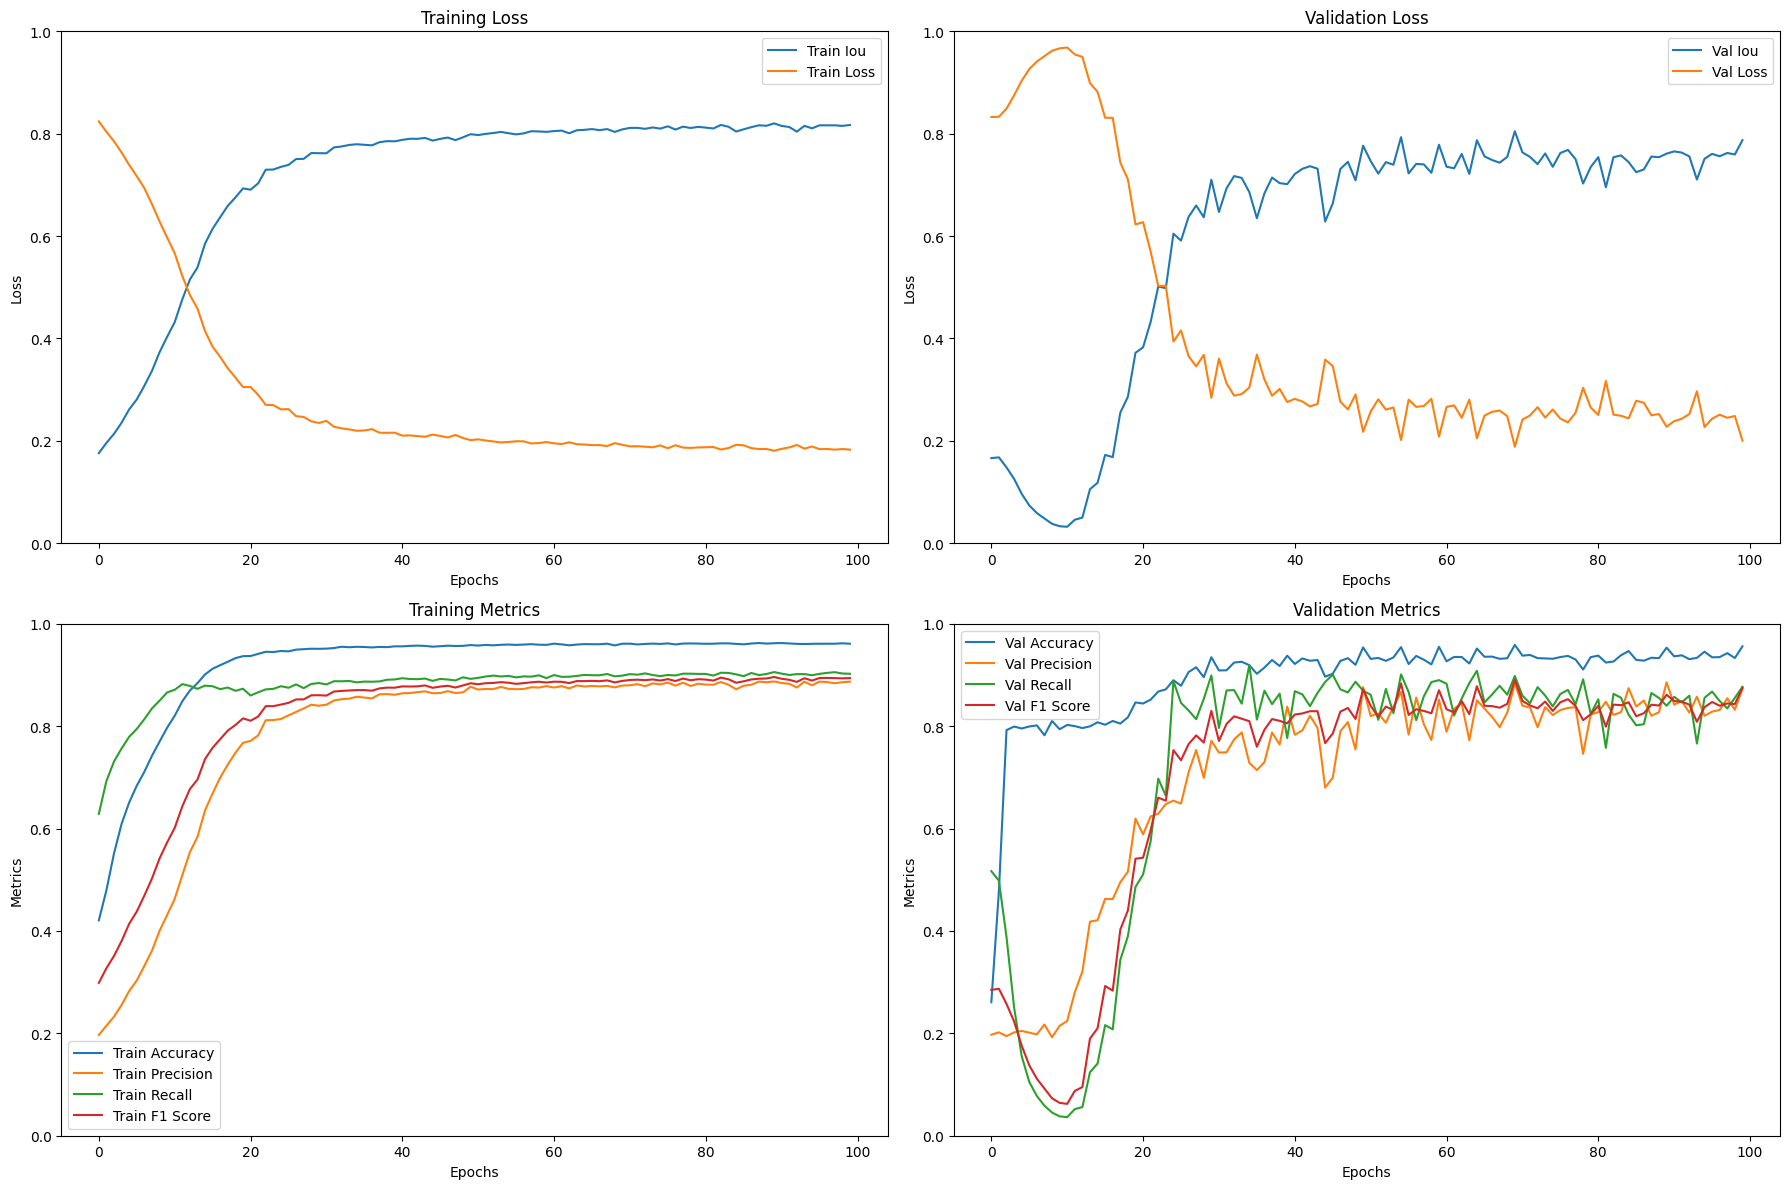

In [ ]:
import matplotlib.pyplot as plt

def print_plot_history(history):
    # Print and plot training and validation loss
    plt.figure(figsize=(18, 12))

    # Plot training loss and IOU score
    plt.subplot(2, 2, 1)
    plt.plot(history['iou_score'], label='Train Iou')
    plt.plot(history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history['val_iou_score'], label='Val Iou')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.legend()

    # Plot training and validation metrics
    plt.subplot(2, 2, 3)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['f1-score'], label='Train F1 Score')
    plt.title('Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.plot(history['val_f1-score'], label='Val F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.legend()

    # Print best values
    print("Best values:")
    print("Best values:")
    for key in history.keys():
        if key != 'epoch':
            best_value = max(history[key])
            print(f"{key}: {best_value}")

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# def print_plot_history(history):
#     # Print and plot training and validation loss
#     plt.figure(figsize=(12, 6))

#     # Plot training loss
#     plt.plot(history['loss'], label='Train loss')

#     # Plot validation loss
#     plt.plot(history['val_loss'], label='Val loss')

#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.show()


print_plot_history(history)

In [ ]:
test_1_labels, test_2_labels = load_labels(TEST_1_PATH, TEST_2_PATH)

Test masks (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Test masks (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
# # Prediction using TTA
# test_1_pred_masks = tta(model, test_1_images)
test_2_pred_masks = tta(model, test_2_images)

  0%|          | 0/106 [00:00<?, ?it/s]

submission

In [ ]:
# import csv
# import os

# # # Prediction
# # # test_1_pp_masks = post_proccess_masks(test_1_pred_masks)
# test_2_pp_masks = post_proccess_masks(test_2_pred_masks)
# # test_2_pp_masks = post_proccess_masks_2(test_2_masks, test_2_labels)



# # Results
# # show_results(test_1_images, test_1_masks, test_1_labels, test_1_pred_masks, test_1_pp_masks, verbose=False)
# show_results(test_2_images, test_2_masks, test_2_labels, test_2_pred_masks, test_2_pp_masks, verbose=False)

# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(y):
#     dots = np.where(y.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def pred_to_rles(y):
#     for i in range(1, y.max() + 1):
#         yield rle_encoding(y == i)


# def submit_data(uuids, preds, original_shapes):
#     with open(SUBMISSION_PATH, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['ImageId', 'EncodedPixels'])

#         for idx, (uid, y) in tqdm(enumerate(zip(uuids, preds))):
#             uid = os.path.basename(uid)
#             y = label(erosion(y, footprint=disk(2)))
#             y_resized = resize(y, (original_shapes[idx][0], original_shapes[idx][1]), mode='constant', order=0, preserve_range=True, anti_aliasing=True)
#             for rle in pred_to_rles(y_resized):
#                 writer.writerow([uid, ' '.join([str(i) for i in rle])])



# submit_data(test_2_ids, test_2_pp_masks, test_2_shapes)

!kaggle competitions submit -c data-science-bowl-2018 -f "{SUBMISSION_PATH}" -m "Message"
# !kaggle competitions submissions -c data-science-bowl-2018

100% 889k/889k [00:00<00:00, 1.37MB/s]
Successfully submitted to 2018 Data Science Bowl 

In [ ]:
import pandas as pd

def submission():
    # Read the CSV file into a DataFrame
    df = pd.read_csv(STAGE_2_SOLUTION_PATH)

    # List of columns to remove
    columns_to_remove = ['Height', 'Width', 'Usage']

    # Remove the specified columns
    df = df.drop(columns=columns_to_remove)

    # Remove rows where 'encodedPixels' column has the value '1 1'
    df = df[df['EncodedPixels'] != '1 1']

    # Write the modified DataFrame back to a CSV file
    df.to_csv(SOLUTION_PATH, index=False)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display

def read_mask_from_csv(test_2_images, test_2_shapes, test_2_pp_masks):
    df1 = pd.read_csv(STAGE_2_SOLUTION_PATH)
    df2 = pd.read_csv(SUBMISSION_PATH)

    image_ids = sorted(list(df1['ImageId'].unique()))

    @interact(idx1=IntSlider(min=0, max=len(image_ids)-1, step=1, value=0, description='Image Index'))
    def plot_masks(idx1):
        image_id = image_ids[idx1]
        mask_rles_1 = df1.loc[df1['ImageId'] == image_id, 'EncodedPixels']
        mask_rles_2 = df2.loc[df2['ImageId'] == image_id, 'EncodedPixels']

        masks_1 = rle_decode(rle_list=mask_rles_1, mask_shape=(test_2_shapes[idx1][0], test_2_shapes[idx1][1]), mask_dtype=np.uint16)
        masks_2 = rle_decode(rle_list=mask_rles_2, mask_shape=(test_2_shapes[idx1][0], test_2_shapes[idx1][1]), mask_dtype=np.uint16)

        @interact(idx2=IntSlider(min=0, max=len(masks_1)-1, step=1, value=0, description='Masks 1 Index'),
                  idx3=IntSlider(min=0, max=len(masks_2)-1, step=1, value=0, description='Masks 2 Index'))
        def plot_individual_masks(idx2, idx3):
            fig, axes = plt.subplots(1, 4, figsize=(15, 5))
            axes[0].imshow(resize(test_2_images[idx1], (test_2_shapes[idx1][0], test_2_shapes[idx1][1])))
            axes[0].set_title('Image from stage 2')

            axes[1].imshow(np.logical_or.reduce(masks_1))
            axes[1].set_title('Mask from STAGE_2_SOLUTION_PATH')

            axes[2].imshow(np.logical_or.reduce(masks_2))
            axes[2].set_title('Mask from SUBMISSION_PATH')

            y = resize(test_2_pp_masks[idx1], (test_2_shapes[idx1][0], test_2_shapes[idx1][1]), order=0, mode='constant', preserve_range='True')
            print(np.unique(y))
            axes[3].imshow(y)
            axes[3].set_title('PP mask')

            plt.show()

read_mask_from_csv(test_2_images, test_2_shapes, test_2_pp_masks)


interactive(children=(IntSlider(value=0, description='Image Index', max=105), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image Index:', max=587), Output…

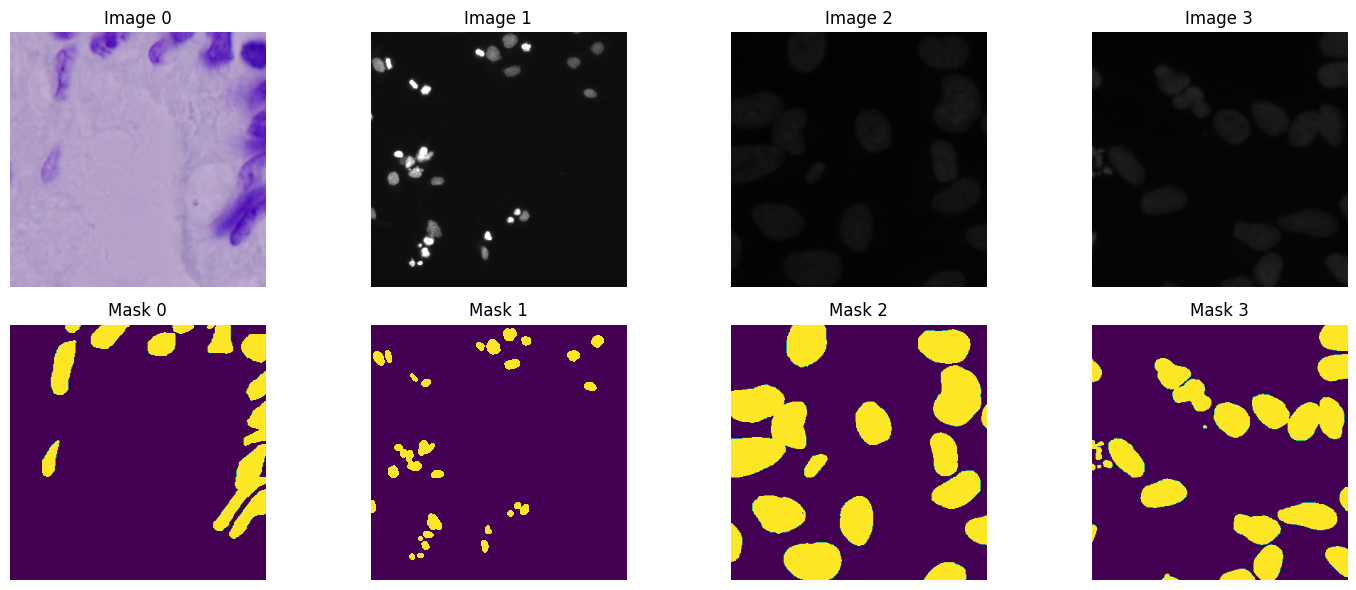

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

def plot_some_images(train_images, train_masks):
    num_images = min(len(train_images), len(train_masks))
    num_rows = 2
    num_cols = 4

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    # Create index widget
    index_slider = widgets.IntSlider(value=0, min=0, max=num_images - 1, description='Image Index:', continuous_update=False)

    def update_plot(index):
        # Clear previous plots
        for ax in axes.flatten():
            ax.clear()

        # Plot images and masks
        for i in range(num_cols):
            if index + i < num_images:
                axes[0, i].imshow(train_images[index + i])
                axes[0, i].set_title(f"Image {index + i}")
                axes[0, i].axis('off')

                axes[1, i].imshow(train_masks[index + i])
                axes[1, i].set_title(f"Mask {index + i}")
                axes[1, i].axis('off')

    # Connect widget to update function
    widgets.interact(update_plot, index=index_slider)

    plt.tight_layout()
    plt.show()

plot_some_images(train_images, train_masks)